# Tutorial 8: Integrals

In this exercise, we will read, plot and analyze a **VTR file** (i.e. VTK Rectilinear Grid) containing the density of $3$ spherical moons via numerical integration, which allows us to easily calculate mass, column densities and center of masses. 

**Data**: The VTR file can be found [here](https://github.com/wbandabarragan/physics-teaching-data/blob/main/3D-data/moons.zip).

### (a) Crate a simple function which reads the file and returns the reshaped $256\times256\times256$ cube along with the appropiate coordinates. Then, plot a $2\rm D$ slice. What do you notice when changing the index of the slice?

Assume the normalization factors are $1 \rm pix$ $ = 25 \,\rm km$ for distance and $1\times10^{10}\,\rm kg/km^{3}$ for density.

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import sympy as sp

In [2]:
# I've recently adopted this format for writing function documentation
def get_density_cube(filename):
    """
    Obtain the density cube of a vtk file.

    Parameters
    ----------
    filename : str, required
        Location of the file.

    Returns
    -------
    rho_3d : array
        Density cube.
    x, y, z : array
        Coordinates along each direction.
    """
    # Get the mesh
    mesh = pv.read(filename)

    # Extract the specified array
    rho_1d = pv.get_array(mesh, "density", preference = "cell")

    # Get the dimensions (the same for the all dimensions)
    dims = mesh.dimensions[0] - 1

    # And reshape the array
    rho_3d = rho_1d.reshape(dims, dims, dims)*1e10

    # Get the coordinates 
    x = np.linspace(mesh.bounds[0], mesh.bounds[1], mesh.dimensions[0])*25
    y = np.linspace(mesh.bounds[2], mesh.bounds[3], mesh.dimensions[1])*25
    z = np.linspace(mesh.bounds[4], mesh.bounds[5], mesh.dimensions[2])*25

    return rho_3d, x, y, z

In [3]:
# Call it
rho_3d, x, y, z = get_density_cube("./Data/moons.vtr")

In [4]:
# Create a 2d meshgrid with +1 in shape
x_2d, y_2d = np.meshgrid(x, y)
print(x_2d.shape, y_2d.shape)

(257, 257) (257, 257)


In [5]:
# Get a slice like this since the moons are not in the same planes
slice_2d = rho_3d[:, :, 200] + rho_3d[:, :, 128] + rho_3d[:, :, 100]

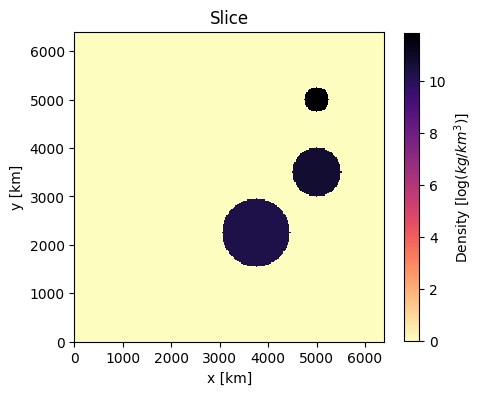

In [6]:
# Plot the slice
plt.figure(figsize = (5, 5))

plot = plt.pcolor(x_2d, y_2d, np.log10(slice_2d + 1),
                  cmap = 'magma_r', shading = 'auto')
plt.colorbar(plot, shrink = 0.80, label = 'Density [$\\log(kg/km^3)$]')

plt.title('Slice')
plt.xlabel('x [km]')
plt.ylabel('y [km]')

plt.gca().set_aspect('equal')
plt.show()
plt.close()

### (b) Knowing the density of each moon is constant and different, create a function which returns the mass of each of them. Then, get the total mass.

In [7]:
# Let's see the different densities in kg/km³
print(np.unique(rho_3d))

[0.e+00 2.e+10 6.e+10 7.e+11]


In [8]:
# Function
def get_mass(density_3d, density, dx):
    """
    Compute the mass of each moon.
    """
    # Get a moon
    moon = density_3d[density_3d == density]

    # Calculate the mass by 'integrating'
    mass = np.sum(moon)*dx**3

    return mass

In [9]:
# Calculate the differentials
dx = abs(x[21]-x[20])
dy = abs(y[21]-y[20])
dz = abs(z[21]-z[20])

print(dx, dy, dz)

25.0 25.0 25.0


In [10]:
# Call the function for each
mass_1 = get_mass(density_3d = rho_3d, density = np.unique(rho_3d)[-1], dx = dx)
mass_2 = get_mass(density_3d = rho_3d, density = np.unique(rho_3d)[-2], dx = dx)
mass_3 = get_mass(density_3d = rho_3d, density = np.unique(rho_3d)[-3], dx = dx)

In [11]:
# See the values
print(f'{mass_1:.2e}, {mass_2:.2e}, {mass_3:.2e}') # kg

4.56e+19, 3.13e+19, 2.87e+19


In [12]:
# Get the mass where density = 0
mass_4 = get_mass(density_3d = rho_3d, density = 0, dx = dx)

# Evidently 
print(mass_4)

0.0


In [13]:
# Get the total mass by adding the mass of each moon
print(f'The total mass is {(mass_1 + mass_2 + mass_3):.2e}kg.')

The total mass is 1.06e+20kg.


In [14]:
# The total mass can be simply gotten with
print(f'The total mass should be: {(np.sum(rho_3d)*dx**3):.2e}kg.')

The total mass should be: 1.06e+20kg.


### (c) Calculate the $2\rm D$ and $1\rm D$ column densities of all moons and visualize them.

In [15]:
# In 2D
column_density_2d = np.sum(rho_3d, axis = 2)*dz

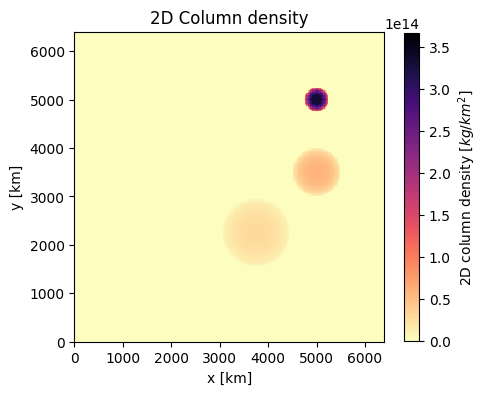

In [16]:
# Plot!
plt.figure(figsize = (5,5))
plot = plt.pcolor(x_2d, y_2d, column_density_2d,
                  cmap = 'magma_r', shading = 'auto')
plt.colorbar(plot, shrink = 0.80, label = '2D column density [$kg/km^2$]')

plt.title('2D Column density')
plt.xlabel('x [km]')
plt.ylabel('y [km]')

plt.gca().set_aspect('equal')
plt.show()
plt.close()

In [17]:
# And 1D where we each row above and get an array
column_density_1d = np.sum(column_density_2d, axis = 1) * dx

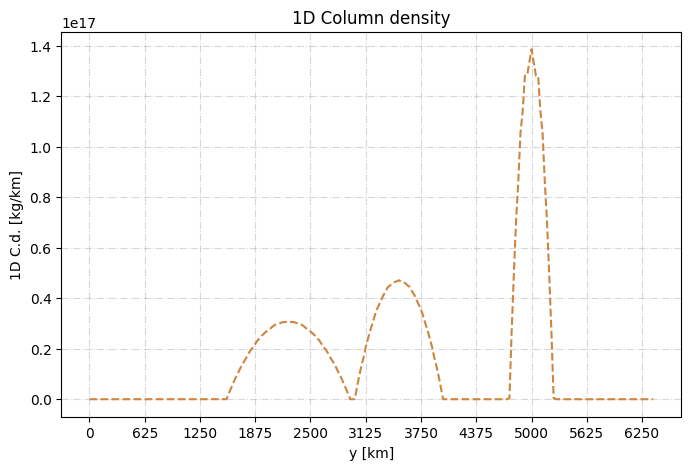

In [18]:
# And plot it
plt.figure(figsize = (8, 5))
plt.plot(column_density_1d, ls = '--', color = 'peru')

plt.title('1D Column density')
plt.ylabel('1D C.d. [kg/km]')
plt.xlabel('y [km]')

# To normalize the x-axis
x_array = np.arange(257) * 25
plt.xticks(np.arange(257)[::25], x_array[::25])

plt.grid(ls = '-.', alpha = 0.5)
plt.show()
plt.close()

The size and density differences are more apparent in this last plot.

### (d) Calculate the center of mass of the system, and of each individual moon. Then, compute the distance and determine which one is the closest to the system center of mass.

In [19]:
# Define these
x_mid = (x[1:] + x[:-1])/2
y_mid = (y[1:] + y[:-1])/2
z_mid = (z[1:] + z[:-1])/2

# Check that the shape is -1 the other
print(x_mid.shape, y_mid.shape, z_mid.shape)

(256,) (256,) (256,)


In [20]:
# Create a function for calculating 3D center of masses
def get_cm(array_3d):
    """
    Get the center of mass of a given 3D array.
    """
    # Calculate the center of mass for the moon
    cm_x = 25*np.sum(np.sum(np.sum(array_3d, axis = 2), axis = 1)*(x_mid))/np.sum(array_3d)
    cm_y = 25*np.sum(np.sum(np.sum(array_3d, axis = 2), axis = 0)*(y_mid))/np.sum(array_3d)
    cm_z = 25*np.sum(np.sum(np.sum(array_3d, axis = 1), axis = 0)*(z_mid))/np.sum(array_3d) 

    return np.array([cm_x, cm_y, cm_z])

In [21]:
# Get the total center of mass
cm_all_moons = get_cm(rho_3d)

In [22]:
# Function to get a moon or two
def get_moon_cm(density_3d, density, dx, two_moons = False):
    """
    Compute the mass of a moon within the whole domain.
    """
    # Get a moon by removing the other two
    moon = np.where(density_3d != density, 0, density_3d)

    # Get the other two moons instead
    if two_moons:
        moon = np.where(density_3d == density, 0, density_3d)
        
    # Calculate the center of mass array
    cm_array = get_cm(moon)

    return cm_array

The moon and center of mass names were choosen to match how they are ordered in density. That is, in terms of higher density: **Moon 1 > Moon 2 > Moon 3**.

In [23]:
# Get the individual center of masses
cm_1 = get_moon_cm(density_3d = rho_3d, density = np.unique(rho_3d)[-1], dx = dx)
cm_2 = get_moon_cm(density_3d = rho_3d, density = np.unique(rho_3d)[-2], dx = dx)
cm_3 = get_moon_cm(density_3d = rho_3d, density = np.unique(rho_3d)[-3], dx = dx)

In [24]:
# For distance, define
d = lambda x, y: np.linalg.norm(x - y)

In [25]:
# Print!
print(f'Moon 1 is at {d(cm_1, cm_all_moons):.3} km from the center of mass.')
print(f'Moon 2 is at {d(cm_2, cm_all_moons):.3} km from the center of mass.')
print(f'Moon 3 is at {d(cm_3, cm_all_moons):.3} km from the center of mass.')

Moon 1 is at 4.37e+04 km from the center of mass.
Moon 2 is at 3.37e+04 km from the center of mass.
Moon 3 is at 4.73e+04 km from the center of mass.


What if we remove the largest and lowest density moon?

In [26]:
# Get the center of mass for the two moons with higher density only
cm_two_moons = get_moon_cm(density_3d = rho_3d, density = np.unique(rho_3d)[-3], dx = dx, two_moons = True)

In [27]:
print(f'Moon 1 is at {d(cm_1, cm_two_moons):.3} km from the center of mass of the two-moon system.')
print(f'Moon 2 is at {d(cm_2, cm_two_moons):.3} km from the center of mass of the two-moon system.')

Moon 1 is at 2.97e+04 km from the center of mass of the two-moon system.
Moon 2 is at 4.32e+04 km from the center of mass of the two-moon system.


Removing that moon makes the center of mass be closer to the high-density moon.

### (e) Given the radii of each moon in pixels: $r_1 = 10\, \rm pix$, $r_2 = 20\, \rm pix$ and $r_3 = 28\, \rm pix$, calculate the mass of each moon *analytically* via integration. Compare results!

The mass can be obtained with
$$
m = \int_V \rho \,dV \,\text{, where}\,\,\, dV = r^{2} \sin \theta \,dr\, d\theta \,d\phi.
$$
Since $\rho$ is constant, the integral to do is
$$
m = \rho \int_0^{2\pi}\int_0^{\pi}\int_0^{R} r^{2} \sin \theta \,dr\, d\theta \,d\phi
$$
To practice, we'll solve the integral with `sympy`. 

---
The steps to follow are always the same:

1. Define the symbols (variables). Like this:

```python
x, y = sp.symbols('x y')
```

2. Define the expression with `sympy` functions only. For example:

```python
z = 21 * sp.sin(x) + 5 * sp.cos(y)
```

3. Now we can use any function the library provides. The following finds the Taylor expansion of $z$ around $y=2$ up to $10$ terms:

```python
taylor_expansion = z.series(y, 2, 10).removeO() # removeO() removes the remainder O-term
```

If you later want to evaluate the expression, I recommend doing something like

```python
# Get an evaluable function
taylor_function = sp.lambdify((x, y), taylor_expansion, 'numpy')

# And simply evaluate
z_0 = taylor_function(x = np.pi, y = 31)
```
That's it :).

---

In [28]:
# Coming back, define our variables
r, R, theta, phi, rho = sp.symbols('r R theta phi rho')

In [29]:
# Define the integrand (volume element in spherical coordinates)
integrand = rho * r**2 * sp.sin(theta)

In [30]:
# Integral over r
integral_1 = sp.integrate(integrand, (r, 0, R))

# Integral over theta
integral_2 = sp.integrate(integral_1, (theta, 0, sp.pi))

# Final integral over phi
mass_expression = sp.integrate(integral_2, (phi, 0, 2*sp.pi))

# See
mass_expression

4*pi*R**3*rho/3

In [31]:
# Since we want to evaluate it
mass_function = sp.lambdify((R, rho), mass_expression, 'numpy')

In [32]:
# Evaluate for each moon
mass_1_sympy = mass_function(R = 10*25, rho = np.unique(rho_3d)[-1])
mass_2_sympy = mass_function(R = 20*25, rho = np.unique(rho_3d)[-2])
mass_3_sympy = mass_function(R = 28*25, rho = np.unique(rho_3d)[-3])

In [33]:
# Print comparison (ratio)
print('The ratios between analytical and numerical calculated masses are:')
print()
print(f'Moon 1: {mass_1_sympy/mass_1:.4}.')
print(f'Moon 2: {mass_2_sympy/mass_2:.4}.')
print(f'Moon 3: {mass_3_sympy/mass_3:.4}.')

The ratios between analytical and numerical calculated masses are:

Moon 1: 1.005.
Moon 2: 1.003.
Moon 3: 0.9999.


## Appendix: Spheres (moons) and VTK generation
You might take a quick look. 

### Spheres

In [34]:
# Little function
def get_sphere(size, radius, interval):
    """
    It creates a 3D cube containing a sphere.
    
    Parameters
    ----------
    size : int, required
        Size of the 3D cube domain.
    radius : int, required
        Radius of the sphere. Should be =< size//2.
    interval : list, float, required
        Two-element list which defines the interval
        of values inside the sphere.

    Returns
    -------
    sphere : array
        3D cube with a sphere inside it.
    """
    # Create coordinates arrays (similar to np.meshgrid)
    x, y, z = np.ogrid[:size, :size, :size]
    
    # Get the center point
    center = size / 2
    
    # Calculate distance from center for each point
    distance = np.sqrt((x - center)**2 + (y - center)**2 + (z - center)**2)
    
    # Create the sphere mask defined with the radius (it's a condition!)
    sphere_mask = distance <= radius
    
    # Create the domain where the sphere is going to be
    sphere = np.zeros((size, size, size))

    # Count the number of points to be filled
    points = np.sum(sphere_mask)
    
    # Fill the sphere with random values in the specified interval
    sphere[sphere_mask] = np.random.uniform(interval[0], interval[1], size = points)
    
    return sphere

In [35]:
# Get 3 spheres with fixed density (interval[0] = interval[1])
low_density_3d = get_sphere(size = 60, radius = 28, interval = [2, 2])
med_density_3d = get_sphere(size = 50, radius = 20, interval = [6, 6])
hig_density_3d = get_sphere(size = 26, radius = 10, interval = [70, 70])

In [36]:
# Create a greater empty domain
domain_3d = np.zeros((256, 256, 256))

# And append each sphere in a different spot
domain_3d[128 - 30:128 + 30, 150 - 30:150 + 30, 90 - 30:90 + 30] = low_density_3d
domain_3d[100 - 25:100 + 25, 200 - 25:200 + 25, 140 - 25:140 + 25] = med_density_3d
domain_3d[200 - 13:200 + 13, 200 - 13:200 + 13, 200 - 13:200 + 13] = hig_density_3d

#### Projection
To see the result, we'll get a projection by adding matrices along some direction.

In [37]:
# Get it with
projection_2d = np.sum(domain_3d, axis = 0)

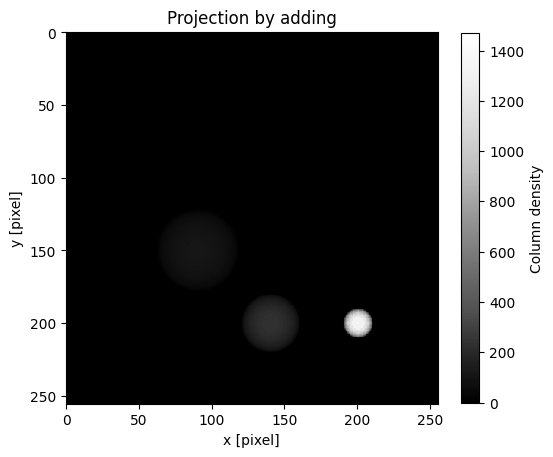

In [38]:
# Plot it!
plt.figure(figsize = (6, 6))

plot = plt.imshow(projection_2d, cmap = "Greys_r")
plt.colorbar(plot, label = 'Column density', shrink = 0.8)

plt.title('Projection by adding')
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]')

plt.gca().set_aspect('equal')
plt.show()
plt.close()

They look like little moons :).

### VTK generation

In [39]:
# Library
from pyevtk.hl import gridToVTK

In [40]:
# Define the coordinates (Notice the + 1 in shape!)
x = np.linspace(0, domain_3d.shape[0], domain_3d.shape[0] + 1)
y = np.linspace(0, domain_3d.shape[1], domain_3d.shape[1] + 1)
z = np.linspace(0, domain_3d.shape[2], domain_3d.shape[2] + 1)

# And export it
gridToVTK(path = './Data/moons', x = x, y = y, z = z, cellData = {'density': domain_3d})

'/home/whyyorlantaken/Documents/Yachay-Tech/Physics/05-Tutorials-Comp-Phys-I/Data/moons.vtr'